# Learning Goals

The goal of this assignment is to develop an understanding of how the brain performs computations at the neuronal level. To do so, you will develop several models of a spiking neuron. By the end of this assignment, you should a) be comfortable with developing models of spiking neurons at different levels of abstraction, from the biologically plausible H-H model to the phenomenological LIF model; b) understand how neurons use their firing rate to represent continuous-valued information; and c) understand the trade-offs involved in spike-based information representation. 

More theoretical information can be found here: https://neuronaldynamics.epfl.ch/online/Ch2.html

Let's first import all the libraries required for this assignment

In [ ]:
import math
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch

# Question 1: The Hodgkin Huxley Neuron
## 1a. 
We will start by implementing the different computational models of a spiking neuron, with the aim of understanding the differences between the different models. We will start with one of the earliest, yet one of the most biologically faithful models of a neuron - The Hodgkin-Huxley (HH) model. Below is the class definition of an HH neuron. Your first task is to fill the different components required to simulate an HH neuron. 

In [ ]:
class HodgkinHuxley():
    """Implementation of Hodgkin Huxley Model"""
    def __init__(self, C_m, g_Na, g_K, g_L, E_Na, E_K, E_L, T, dt):
        """
        :param C_m: membrane capacitance in uF/cm^2
        :param g_Na: Sodium conductance in mS/cm^2
        :param g_K: Potassium conductance in ms/cm^2
        :param g_L: Leak maximum conductance
        :param E_Na: Sodium Nernst reversal potential in mV
        :param E_K: Potassium Nernst reversal potential in mV
        :param E_L: Leak Nernst reversal potential in mV
        :param T: Simulation timesteps
        :param dt: Integration time 
        
        This function is complete. You do not need to do anything here.
        """
        self.C_m = C_m 
        self.g_Na = g_Na 
        self.g_K = g_K
        self.g_L = g_L
        self.E_Na = E_Na
        self.E_K = E_K
        self.E_L = E_L
        self.T = T
        self.dt = dt
        self.t = np.arange(0, self.T, self.dt) #time to integrate over
    
    def alpha_m(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_m
        
        Fill in the equation for alpha_m
        """
        return 0.1*(V + 40)/(1  - math.exp( -(V+ 40)/10))
   
    def beta_m(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_m
        
        Fill in the equation for beta_m
        """
        return 4*(math.exp(-(V+65)/18))
    
    def alpha_h(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_h
        
        Fill in the equation for alpha_h
        """
        return 0.07*math.exp(-(V+65)/20)
    
    def beta_h(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_h
        
        Fill in the equation for beta_h
        """
        return 1/(1 + math.exp(-(V+35)/10))
    
    def alpha_n(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: alpha_n
        
        Fill in the equation for alpha_n
        """
        return (0.01*(V + 55))/(1 - math.exp(-(V + 55)/10))
    
    def beta_n(self, V):
        """
        Channel gating kinetics
        :param V: membrane voltage
        :return: beta_n
        
        Fill in the equation for beta_n
        """
        return 0.125*(math.exp(-(V+65)/80))
    
    def I_Na(self, V, m, h):
        """
        Membrane Sodium current
        :param V: membrane voltage
        :param m: gating variable m
        :param h: gating variable h
        :return: sodium current I_Na
        
        Fill in the equation for I_Na
        """
        return self.g_Na*(V - self.E_Na)*(math.pow(m,3))*h
    
    def I_K(self, V, n):
        """
        Membrane Potassium current
        :param V: membrane voltage
        :param h: gating variable h
        :return: Potassium current I_K
        
        Fill in the equation for I_K
        """
        return self.g_K*(V - self.E_K)*(math.pow(n,4))
    
    def I_L(self, V):
        """
        Membrane Leak current
        :param V: membrane voltage
        :return: Leak current I_L
        
        Fill in the equation for I_L
        """
        return self.g_L*(V - self.E_L)

    def I_inj(self, t):
        """
        External current
        :param t: time
        :return: step up to 10 uA/cm^2 at t>100
                step down to 0 uA/cm^2 at t>200
                step up to 35 uA/cm^2 at t>300
                step down to 0 uA/cm^2 at t>400
        
        This function is complete. You do not need to do anything here.
        """
        return 10*(t>100) - 10*(t>200) + 35*(t>300) - 35*(t>400)
    
    @staticmethod
    def computeDerivatives(X, t, self):
        """
        Function to integrate membrane potential and activation variables
        :param X: array containing the integration variables: V, m, h, n
        :param t: time
        :return dVdt: increment in membrane voltage
                dmdt: increment in m
                dhdt: increment in h
                dndt: increment in n
        
        Fill in the update equations for dVdt, dmdt, dhdt, dndt
        """
        V, m, h, n = X #unwrap X into the membrane potential and activation variables
        dVdt =  (self.I_inj(t) - self.I_Na(V, m, h) - self.I_K(V , n) - self.I_L(V))/self.C_m
        dmdt =  self.alpha_m(V)*(1-m) - (self.beta_m(V)*m)
        dhdt =  self.alpha_h(V)*(1-h) - (self.beta_h(V)*h)
        dndt =  self.alpha_n(V)*(1-n) - (self.beta_n(V)*n)
        return dVdt, dmdt, dhdt, dndt
    
    def run(self):
        """
        Main function to simulate HH neuron and plot voltage and current against time. This part is complete. DO NOT change this code. You do not need to fill anything here. 
        """
        X = odeint(self.computeDerivatives, [-65, 0.05, 0.6, 0.32], self.t, args=(self,))
        V, m, n, h = X[:, 0], X[:, 1], X[:, 2], X[:, 3]
        plt.figure()
        plt.subplot(2,1,1)
        plt.title('Hodgkin-Huxley Neuron')
        plt.plot(self.t, V, 'k')
        plt.ylabel('V')
        
        plt.figure()
        plt.subplot(2,1,2)
        i_inj = [self.I_inj(t) for t in self.t]
        plt.plot(self.t, i_inj, 'k')
        plt.xlabel('t')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        plt.ylim(-1, 40)
        
        plt.show()

## 1b. 
Initialize an HH neuron using a proper set of parameters; then run the simulation. You should be able to get a plot depicting how the Voltage and Current of the neuron change with time. 

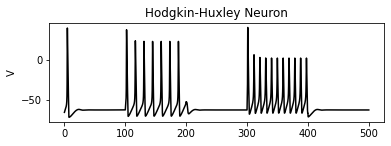

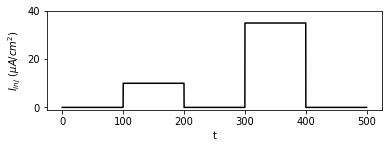

In [ ]:
#1. Initialize an hh neuron using the class definition above
model = HodgkinHuxley(C_m = 1, g_Na = 100, g_K = 36, g_L = 0.3, E_Na = 55, E_K = -72, E_L = -49, T =500, dt =0.01)
#2. Run the hh neuron simulation
model.run()

## 1c. 
The beauty of a neurophysiologically accurate model of a neuron is that it allows the simulation of several phenomena that can take place in the brain. Assume that you administer a drug named Tetrodotoxin (TTX), which is a potent neurotoxin that inhibits the voltage-gated sodium channels, and therefore decreases the sodium current. Simulate the effects that administering TTX would have on the neural firing.  Do the same for another drug, pronase,
which eliminates sodium inactivation. 

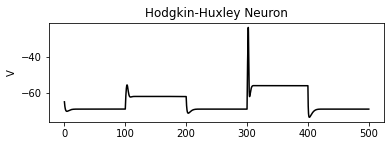

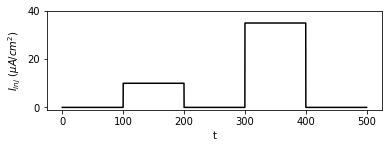

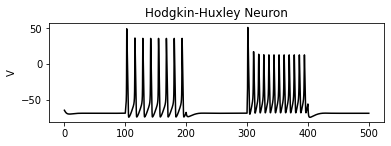

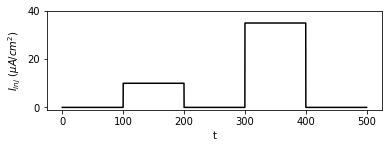

In [ ]:
#1. Initialize an hh neuron to simulate TTX   -> since inhibitting would mean decreasing the conductivity of the Na+ ions
model_TTX = HodgkinHuxley(C_m = 1, g_Na = 5 , g_K = 35, g_L = 0.3, E_Na = 55, E_K = -77, E_L = -65, T =500, dt =0.001)
#2. Run the hh neuron simulation
model_TTX.run()
#3. Initialize an hh neuron to simulate pronase
model_pronase = HodgkinHuxley(C_m = 1, g_Na = 80, g_K = 20, g_L = 0.1, E_Na = 55, E_K = -77, E_L = -65, T =500, dt =0.001)
#4. Run the hh neuron simulation
model_pronase.run()

# Question 2: The Izhikevich Neuron

## 2a.
We will now implement an Izhikevich (Izhi) neuron model. Below is the class definition of an Izhi neuron. Like before, your task is to fill in the different components required to simulate an Izhi neuron. You should notice one key difference in the implementation: While our HH implementation relied on the odeint libary from scipy for integration, here we will use 'Euler's method' to integrate. The Euler's method is very intuitive, simple, and can be easily implemented. For your reference, the dynamics of an Izhi neuron are described in equations 1, 2, 3 in the paper: https://www.izhikevich.org/publications/spikes.pdf

In [ ]:
class Izhi():
    """Implementation of the Izhikevich neuron Model"""
    def __init__(self, a, b, c, d, Vth, T, dt):
        """
        :param a, b, c, d: Izhi neuron parameters
        :param Vth: Voltage threshold for spiking
        :param T: Simulation timesteps
        :param dt: Integration time 
        
        This function is complete. You do not need to do anything here.
        """
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.Vth = Vth
        self.u = self.b * self.c #initialize u
        self.T = T
        self.dt = dt
        self.t = np.arange(0, self.T, self.dt)
        self.I = 10 #Input stimulus current
        
    def run(self):
        """
        Main function to simulate Izhi neuron and plot voltage and current against time. Fill in the update equations for du, dv, v[t] and u[t] and resetting on spiking.
        """
        V = np.zeros(len(self.t)) #Initialize a numpy array containing the membrane voltages for all the timesteps
        V[0] = self.c #Initial membrane voltage is the rest potential, defined by the parameter 'c'
        u = np.zeros(len(self.t)) #Initialize a numpy array containing u for all the timesteps
        u[0] = self.u #Initial u
        
        for t in range(1, len(self.t)): #the time loop for performing euler's integration
            dv =  0.04*math.pow(V[t-1],2) + 5*V[t-1] + 140 - u[t-1] + self.I
            du =  self.a*(self.b * V[t-1] - u[t-1])
            V[t] = V[t-1] + dv 
            u[t] = u[t-1] + du
            
            #condition for when membrane potential is greater than the threshold
            if V[t] >= self.Vth:
                V[t] = self.c 
                u[t] = u[t] + self.d
                
        #plotting
        """This function is complete. You do not need to do anything here"""
        plt.figure()
        plt.subplot(2,1,1)
        plt.title('Izhi Neuron')
        plt.plot(self.t, V, 'k')
        plt.ylabel('V')
        
        plt.figure()
        plt.subplot(2,1,2)
        i_inj = [self.I for t in self.t]
        plt.plot(self.t, i_inj, 'k')
        plt.xlabel('t')
        plt.ylabel('$I_{inj}$ ($\\mu{A}/cm^2$)')
        
        plt.show()

## 2b. 
Initialize an Izhi neuron with the correct parameters and run the simulation. You should again be able to get a plot depicting how the Voltage and Current of the neuron change with time. 

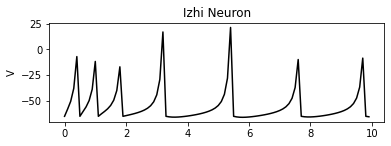

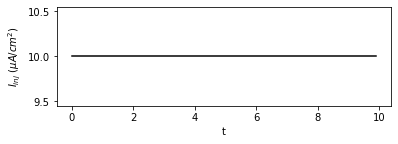

In [ ]:
#1. Initialize an izhikevich neuron with the appropriate parameters
model_izhi = Izhi(a =0.02 , b = 0.2, c = -65, d = 2 , Vth = 30, T = 10, dt =0.1)
#2. Run the simulation and obtain the results
model_izhi.run()

## 2c.
Change the parameters of the Izhi neuron in the code to replicate two different patterns identified in neurons, e.g., bursting and adaptation. You can find the parameters for several different Izhi models here: https://www.izhikevich.org/publications/spikes.pdf

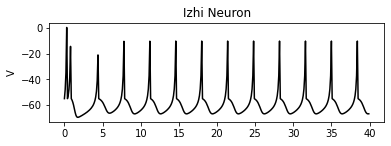

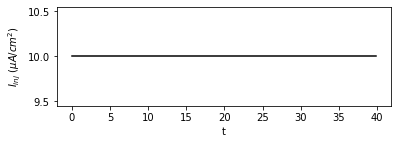

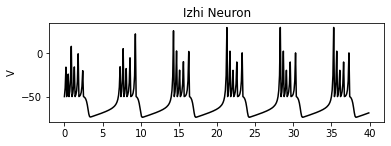

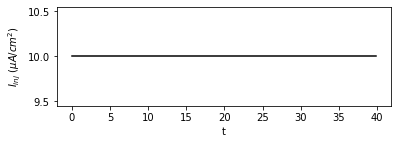

In [ ]:
#Write your implementation of the bursting and chattering neuron here

#1. Initialize an izhikevich neuron with the appropriate parameters
model_izhi_bursting = Izhi(a =0.02 , b = 0.2, c = -55, d = 4 , Vth = 30, T = 40, dt =0.1)
model_izhi_chattering = Izhi(a =0.02 , b = 0.2, c = -50, d = 2 , Vth = 30, T = 40, dt =0.1)
#2. Run the simulation and obtain the results
model_izhi_bursting.run()
model_izhi_chattering.run()

# Question 3: The LIF Neuron

## 3a. 
In this question, you will implement the almighty leaky integrate and fire neuron (LIF). The LIF neuron is the most widely-used model of a neuron in the SNN literature and you will be using it a lot for your course assignments and for your project. Below is the class definition of an LIF neuron. Just like the Izhi neuron, we will use Euler's method to perform integration. There is one key difference however: For HH and Izhi implementations, the neuron was taking current as the input. In our LIF implementation, the neuron takes spike-trains as inputs and produces spike-trains as output, similarly to how a real neuron works. 

As a hint, we provide here a discrete-time version of an LIF neuron:

* First, integrate the input spikes into current with some decay factor

$$C[t] = C[t-1] * current\_decay + input\_spike[t]$$

* Then, integrate the current  into voltage with some decay factor

$$V[t] = V[t-1] * voltage\_decay + C[t]$$

* Lastly produce a spike if the voltage exceeds the threshold, and reset voltage

$$if V[t] >= Vth  \\ output\_spike[t] = 1 \ and \ V[t] = Rest\_Potential $$

In [ ]:
class LIF():
    """Implementation of Leaky integrate and fire neuron Model"""
    def __init__(self, dc, dv, Vth, Vr):
        """
        :param dc: Decay factor for current
        :param dv: Decay factor for voltage
        :param Vth: Voltage Threshold
        :param Vr: Rest potential 
        
        This function is complete. You do not need to do anything here
        """
        self.dc = dc
        self.dv = dv
        self.Vth = Vth
        self.Vr = Vr
    
    def run(self, in_spikes):
        """
        Main function to simulate LIF neuron
        :param in_spikes: Input spike train
        :return out_spikes: output spike train
        
        Fill in the parts for updating Cm, Vm, and the condition for spiking and resetting
        """
        Vm, Cm, out_spikes = [np.zeros(len(in_spikes)) for _ in range(3)] #initialize the state variables
        for t in range(1, len(in_spikes)): #Time loop to perform Euler's Integration
            Cm[t] =  Cm[t-1] * self.dc + in_spikes[t]
            Vm[t] =  Vm[t-1] * self.dv + Cm[t]
            #condition for when membrane potential is greater than the threshold
            if Vm[t] >= self.Vth:
              Vm[t] = self.Vr 
              out_spikes[t] = 1 
        return out_spikes

## 3b. 
Based on the class definition above, create an LIF neuron with the following parameters: dc = 0.5, dv = 0.5, Vth = 0.50, Vr = 0. 
Then apply to the neuron a random spike train for 15 timesteps. You might find the following numpy package useful to generate the input spike train:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

Simulate the neuron and print input and output spikes. 

In [ ]:
#1. Create an LIF neuron with the required parameters using the class definition above
model_LIF = LIF(dc  = 0.5, dv = 0.5, Vth = 0.5, Vr= 0)
#2. Generate a random input spike train of 15 timesteps using the numpy random choice library function
input_spikes = np.random.choice([0,1],15 , replace = True, p=[0.5,0.5])
#3. Print the input spikes
print("Input Spikes:",input_spikes)
#4. Stimulate the LIF neuron with input spikes and return the output spikes
output_spikes = model_LIF.run(input_spikes)
#5. Print the output spikes
print("Output Spikes:", output_spikes)

Input Spikes: [1 0 1 1 1 1 0 1 0 1 1 0 0 0 0]
Output Spikes: [0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0.]


# Question 4: Biology vs. Efficiency
Now that you have simulated spiking neuron models at different levels of abstraction, we will learn how to differentiate between the three neuron models that we have developed, based on the following criteria:
* Biological realism
* Computational Efficiency

Can you describe for what tasks might you need an HH model? For what tasks would an LIF neuron be a better alternative?
*Hint*: Why one should use a neuron model that replicates several of the neuron's mechanisms vs. using a model that emulates the neuron as a spike-in-spike-out black box. 

## Answer 4:



The choice of neuron model to use in a particular task at hand and depends on several factors, including the level of biological realism required, the complexity of the computational task, and the computational efficiency.
 
 
The **Hodgkin-Huxley (HH) model** is a highly biologically realistic neuron model that is based on a large number of parameters that represent the ionic currents and membrane properties of real neurons.As it is a biologically realistic model that is capable of simulating a wide range of complex neural phenomena.The HH model is useful for tasks that require high biological fidelity, such as studying the behavior of individual neurons or small neural circuits, or investigating the dynamics of ion channels and synaptic currents. The HH model can be used to investigate complex behaviors such as action potential initiation, firing patterns that are sensitive to input frequency, propagation, bursting and synaptic plasticity, which are difficult to capture with simpler neuron models.
 
However, this high level of detail also makes the HH model computationally expensive and can be computationally inefficient for large-scale simulations, such as simulating large neural networks or brain-scale models. 
HH models can require **high computational resources**, especially when simulating large networks of neurons.
 
Whereas,
The **LIF model** is a "**spike-in-spike-out black box**" model that is based on a single differential equation that describes the neuron's membrane potential.
The LIF model is useful for tasks that require efficient simulation of large neural networks with millions of neurons and billions of synapses, such as machine learning applications, where the focus is on capturing statistical properties of the data rather than the detailed biophysical mechanisms of individual neurons. The LIF model can also be used for investigating basic neural phenomena, such as population coding, synchronization, and network dynamics, where the **computational efficiency** is crucial. It is also used for
Simulating large-scale neural networks with simple spiking dynamics, such as feedforward networks for image recognition.
Real-time control of robots or prosthetics using spiking neural networks.
Investigating the impact of network structure and connectivity on neural dynamics, such as studying the emergence of synchrony or oscillations in networks.
 
 
In summary, the choice of neuron model depends on the specific task , with highly biologically realistic models such as the HH model being useful for investigating detailed biophysical mechanisms of individual neurons or small neural circuits , while simpler and computationally efficient models such as the LIF model being better suited for large-scale simulations of neural networks and machine learning applications.


# Question 5: Tuning Membrane Properties of the LIF neuron
## 5a.
In this question, you will understand how to tune the membrane properties of an LIF neuron. First, generate 19 inputs in the form of random spike trains of length 50, i.e. 50 timesteps. The inputs will have different levels of probabilities for spike generation, that ranges between 0.1 and 1.0 with step size of 0.05. In other words, you will create 19 spike trains with the first spike train having the probability of 0.1 to generate spikes at any timestep, the second spike train will have the spike generation probability of 0.15, and so on. 

Simulate an LIF neuron with the parameters defined in Question 3b. You will now drive the neuron model with the 19 randomly generated input spike trains that you have created, and compute the output spike train. 
At the same time, compute the input firing rate and output firing rate for each simulation. Firing rate is defined as the mean of the spike train, i.e. total number of spikes/timesteps

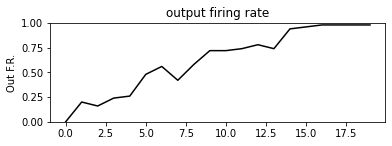

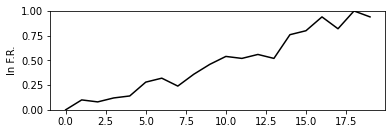

In [ ]:
def lif_behavior(lif):
    """Function to understand the behavior of LIF neuron for different densities of spike inputs
    :param lif: An instance of the LIF neuron
    """
    #1. Create lists to store the input and output firing rates
    in_fr = [] #input firing rate
    out_fr = [] #output firing rate
    
    #2. Create a list of probabilities: from 0.1 to 1.0 with step size of 0.05. You might find the numpy arange function helpful here.
    probabilities = [[1-p/100,p/100] for p in range(1,100,5)]
    
    #3. Loop through the range of probabilities
    for pb in probabilities:
        in_spikes =  np.random.choice([0,1],50, replace = True, p= pb )
        
        #compute input firing rate and append to the in_fr list
        in_fr.append(np.mean(in_spikes))
        
        #obtain output spikes by applying the input to the LIF neuron
        out_spikes  = lif.run(in_spikes)
        
        #compute output firing rate and append to the out_fr list
        out_fr.append(np.mean(out_spikes))

    #Plot the input and output firing rates. Nothing to do here. This part is complete
    plt.figure()
    plt.subplot(2,1,1)
    plt.title('output firing rate')
    plt.plot(out_fr, 'k')
    plt.ylabel('Out F.R.')
    plt.ylim([0,1])

    plt.figure()
    plt.subplot(2,1,2)
    plt.plot(in_fr, 'k')
    plt.ylabel('In F.R.')
    plt.ylim([0,1])
    plt.show()

#Run the lif behavior function for the LIF neuron that we created previously
lif = LIF(dc  = 0.5, dv = 0.5, Vth = 0.5, Vr= 0)
lif_behavior(lif)

## 5b. 
Describe how soon does the output firing rate start to saturate? Can you describe why this could be problematic? *Hint: Think from the point of view of distinguishing between two different inputs based on firing activity*

## Answer 5b.

The Output firing rate above starts to saturate at 0.75 meaning that once the input current has approached the neuron's firing threshold which is 0.5 here.
 
This is problematic because it becomes difficult to distinguish between two firing rates which are close to saturation .As they are too similar and the small differences in the input currents may not produce distinct firing rates. This will lead to errors in signal processing and reduced accuracy.

solution :
1. temporal coding or population coding, which rely on patterns of firing activity across multiple neurons rather than the firing rate of a single neuron.
2. using multiple neurons with different tuning curves, or incorporating feedback mechanisms to adjust the neuron's threshold potential dynamically. 










## 5c. 
Change the membrane properties of the LIF neuron to resolve the issue of saturation. In other words, experiment on setting different parameter values that do not allow the output firing rate to saturate so early. *Hint: You may want to start by changing one variable at a time, and see its effect. Try to move it slightly, or abruptly, up or down. Then move to the next parameter, until you see what is its effect on the neuron's output.* 

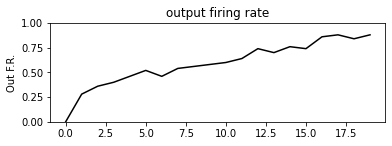

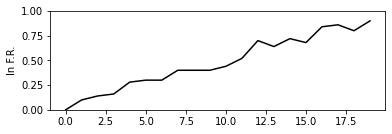

In [ ]:
#1. Create an LIF neuron with appropriately tuned membrane properties
lif = LIF(dc  = 0.2, dv = 10, Vth = 0.5, Vr= 0)
#2. Call the lif behavior function on the tuned lif neuron
lif_behavior(lif)

## 5d.
Based on the above results, can you describe how changing the H-H parameters changes the voltage threshold of a spiking neuron as a function of the input spikes?

## Answer 5d.

The Hodgkin-Huxley (H-H) model is complex model than the LIF model, as it includes multiple voltage-dependent conductances. In the H-H model, changing the parameters of the sodium and potassium conductances can affect the voltage threshold of the neuron.


1. As sodium conductance increses -> neuron voltage threshold becomes more sensitive to input spikes -> fewer input spikes to fire action potential

2. As sodium conductance decreases -> neuron voltage threshold becomes less sensitive to input spikes -> more input spikes to fire action potential

3. As potassium conductance increses -> neuron voltage threshold becomes less sensitive to input spikes -> more input spikes to fire action potential

4. As potassium conductance decreases -> neuron voltage threshold becomes more sensitive to input spikes -> less input spikes to fire action potential

Overall, changing the H-H parameters can alter the voltage threshold of a spiking neuron in complex ways that depend on the strength and timing of input spikes, as well as the conductances in the neuron.


# Question 6: Encoding continuous inputs into spikes
## 6a.
Now we will understand how we can represent continuous-valued inputs as spikes so that drive our spiking neuron. Describe two prominent ways to encode a continuous-valued input into the spiking activity of a neuron. 

## Answer 6a.

#1.
There are several ways to encode continuous-valued input into the spiking activity of a neuron, but two prominent methods are:

Rate coding: In rate coding, the frequency of spiking of a neuron is directly proportional to the magnitude of the input. The higher the input value, the more spikes are generated by the neuron.
Effective for low frequency inputs
Ex : 10 spikes for representing 1 and 20 spikes to reprsent 2

Temporal coding: In temporal coding, the information is encoded in the precise timing of the spikes generated by the neuron. In this method, the input value is converted into a pattern of spike timing rather than a rate of spiking.

1. Input represented as time between spikes 
2.  i) 0 represented as no spike 
   ii) 1 represented as a spike every 5ms 
  iii) 0.5 represented as a spike evry 10ms

it requires higher temporal precision and is more susceptible to noise.
The higher the input value, the shorter the time interval between spikes.





## 6b. 
So far we have learned how we can stimulate a spiking neuron using spike inputs. In this exercise, you will learn how to encode real-world data into spikes that can then be fed as inputs to the spiking neuron. We will take a digit from the popular MNIST dataset as an example. First let's see what a sample digit from the MNIST image looks like. For this, we need to create a loader for the MNIST dataset using a Pytorch function called datasets.MNIST. You do not need to know what a loader is for now. Just understand the two important arguments of the function: The first argument is the directory where the MNIST dataset will be downloaded. The third argument is the set download option. This should be true for the first time when you run this cell to allow you to download the MNIST data into your directory. You can set it to false if the MNIST data has already been downloaded. 

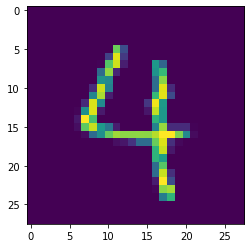

In [ ]:
#Create a loader
mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

#You can access any sample digit from the MNIST dataset using simple indexing mnist[idx]. This returns the digit and the label. We are only interested in the digit. 
#x, _ = random.choice(mnist)
x, _ = mnist[24] # uncomment this line if you want to fix the target image

#Convert to numpy
x = x.numpy()[0]

#Visualize
plt.imshow(x)

Let's now encode the image in the form of spikes using rate-encoding. Suppose that each pixel in the image needs to be encoded in a spike train of length 1. The steps to encode are outlined below:
* For each pixel in the image, sample a random number.
* If the pixel intensity is greater than the generated random number, output a spike. 
* Repeat for as many timesteps as you need to encode the image for. 
* Repeat for all pixels

In [ ]:
import random
import math

#0. Decide the number of spike train here. let us say n_spike = 1 here.
n_spike = 3 
"""
Spike trains are a sequence of electric potentials, called spikes,that are recorded over an interval of time and represent the spike firing of the brain within the given time interval.
"""
#1. Use the numpy.random.rand function to encode the MNIST image into spikes
def randomRateEncoder(image):
  randomized_image = np.random.rand(image.shape[0], image.shape[1])
  encoded_image = image - randomized_image
  encoded_image[encoded_image >=0] =1
  encoded_image[encoded_image < 0] =0
  encoded_image.reshape([image.shape[0],image.shape[1],1])
  return encoded_miage

#2. Output the shape of the spike-encoded image using numpy.shape (hint: the spike-encoded image should be a 3d arraay)
Spike_train_encimages = []
for i in range(n_spike):
  Spike_train_encimages.append(randomRateEncoder(x))
Spike_train_encimages = np.array(Spike_train_encimages)
print(Spike_train_encimages.shape)

(3, 28, 28)


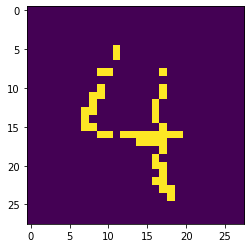

In [ ]:
plt.imshow(Spike_train_encimages[0])  # single encoded image

## 6c. 
Now, we will decode the image back from the spike-based representation. Can you think of a way to get the pixel values back? *Hint: Think aggregate measures on the spike trains for each pixel. Aggregation means compressing of the channel from n to 1.*

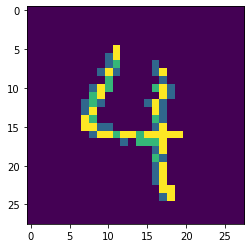

In [ ]:
#1. Compute some aggregate measure of spike trains for each pixel to get the image back. Numpy aggregate functions might be useful here

"""Lets aggregate them by taking the mean of the encoded spike trains"""
reconstructed_image = np.mean(Spike_train_encimages , axis = 0)

#2. visualize the reconstructed image
plt.imshow(reconstructed_image)

Is it possible to get the exact image back? Why/Why not?

## Answer 6c.

No, it is not possible to get the exact same image after encoding an image using rate encoding and then decoding it.

Rate encoding is a lossy compression technique, which means that some information is lost during the encoding process in order to reduce the amount of data required to represent the image. The higher the encoding compression the more the loss of information.

## 6d. 
Can you think of a way to encode the image into spikes in a way such that the decoded image looks as close as possible to the original image? *Hint: Think timesteps*

In [ ]:
#1. Create a "better" encoding of the image

import random
import math

#0. Decide the number of spike train here. let us say n_spike = 1 here.
n_spike = 3 
def timeEncoding(image):
  enc_time = []
  for row in image :
    for col in row:
      enc_time.append(round(col,1))
    enc_time.append(-1)
  return enc_time

#2. Output the shape of the spike-encoded image using numpy.shape (hint: the spike-encoded image should be a 3d arraay)

# encode image function:
def time_seq(enc_time):
  time_sequence = []
  for val in enc_time:
    time_interval = np.zeros(11).astype(int)
    if val < 0:
      time_interval[0] = -1
      time_sequence.extend(time_interval) 
      continue
    time_interval[int(val*10)] = 1
    time_sequence.extend(time_interval)
  return time_sequence

#visualize the encode function:
enc_img = timeEncoding(x)
time_seqq = time_seq(enc_img)
print(len(time_seqq))

#2. Compute and visualize the decoded image


8932


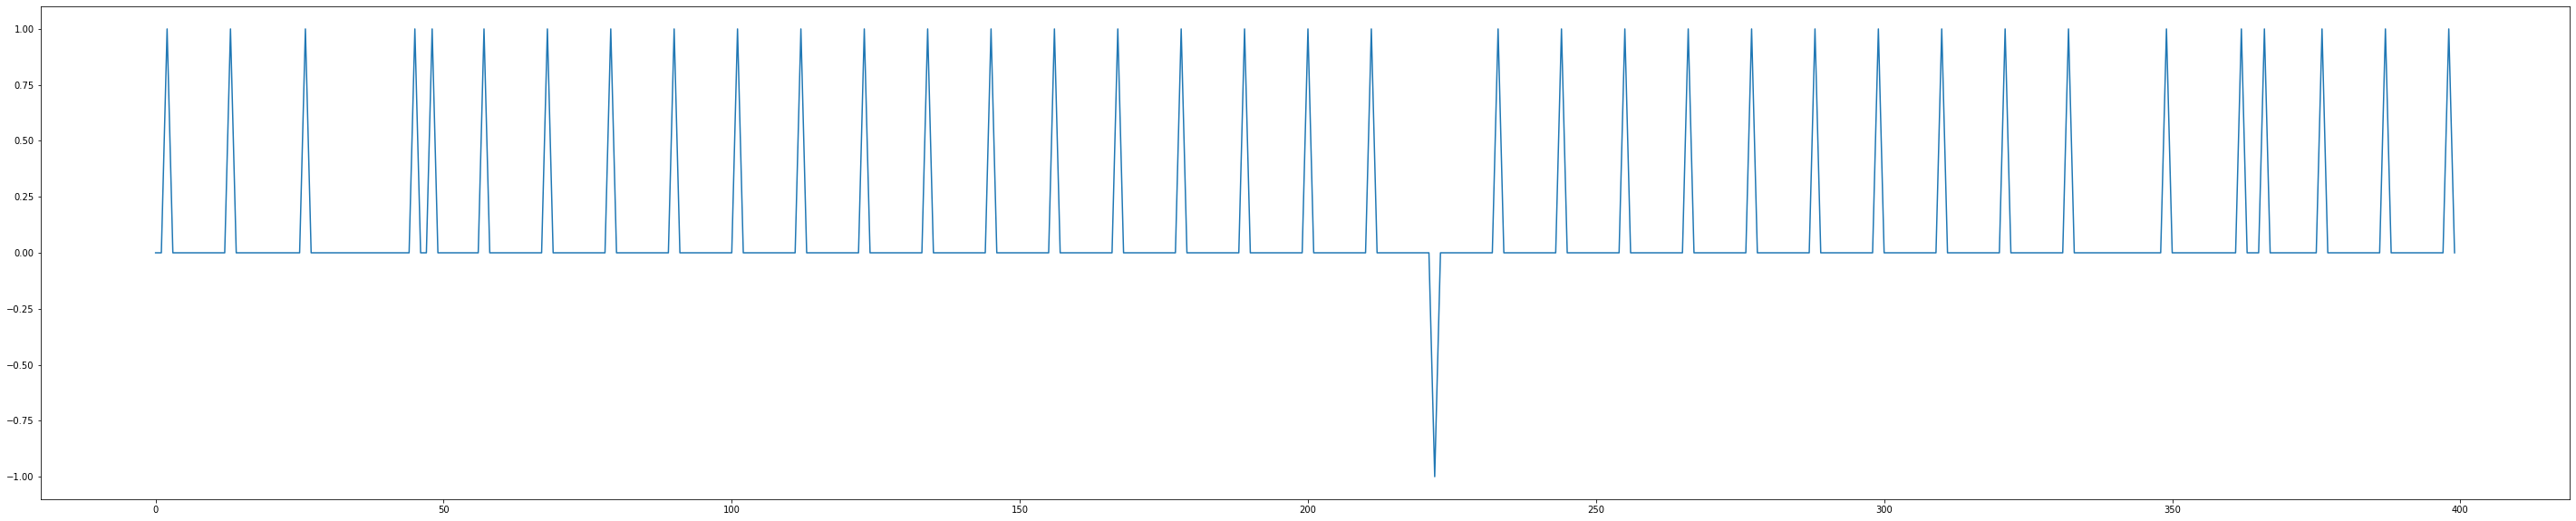

In [ ]:
t = np.arange(400)
fig = plt.figure(figsize=(50,10))
ax = plt.axes()
plt.plot(t,time_seqq[2000:2400])

In [ ]:
#decode the image :

def decode_img(time_seqq):
  reconstructed_image = []
  reconstructed_row = []
  for i in range(0,len(time_seqq),11):
    time_interval = time_seqq[i:i+11]
    try:
      val = time_interval.index(1)
      reconstructed_row.append(val)
    except:
      reconstructed_image.append(reconstructed_row)
      reconstructed_row = []
  print(reconstructed_image)
  return reconstructed_image


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 10, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 8, 1, 0, 0, 0, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 8, 1, 0, 0, 0, 0, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 0, 0, 0, 0, 0, 4, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 8, 4, 0, 0, 0, 0, 0, 4, 8, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 5, 8, 1, 0, 0, 0, 0, 0, 6, 

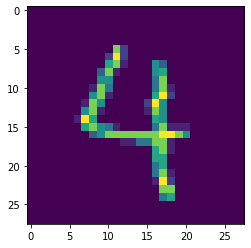

In [ ]:
restruct_img = decode_img(time_seqq)
restruct_img = np.array(restruct_img)
plt.imshow(restruct_img)

If each intensity pixel is represented with a value between [0, 255], what would be a reasonable timestep to encode it accurately? What might be a disadvantage of this solution?

A: time step could be 257 denoting where time instance 0-255 can be used to represent the pixel intensity and 256 to represent next line. but this would lead to high memory usage


## Answer 6d. 
Double click to write your response to Question 6d. here

## 6e

Can you try at least **two** other aggregation functions to decode the images and describe the differences among them.

3

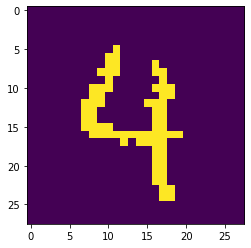

In [ ]:
#1 same struction as 6c
reconstructed_image = np.max(Spike_train_encimages , axis = 0)
#2. visualize the reconstructed image
plt.imshow(reconstructed_image/Spike_train_encimages.shape[0])

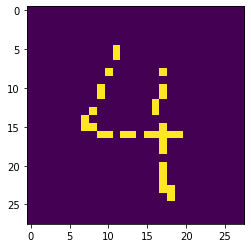

In [ ]:
#1 same struction as 6c
reconstructed_image = np.min(Spike_train_encimages , axis = 0)
#2. visualize the reconstructed image
plt.imshow(reconstructed_image/Spike_train_encimages.shape[0])


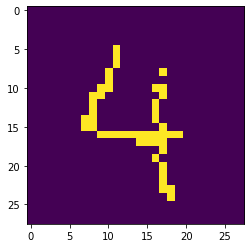

In [ ]:
reconstructed_image = np.median(Spike_train_encimages , axis = 0)
#2. visualize the reconstructed image
plt.imshow(reconstructed_image/Spike_train_encimages.shape[0])


## Answer 6e. 

The only key differnce is:

Average Aggregator -> reaches closest to original img

max, min , median aggregator -> doesn't produce the true img but store information